# GPT(Generative Pre-trained Transformer) 2

* 참고: https://github.com/NLP-kr/tensorflow-ml-nlp-tf2

* OpenAI에서 GPT 모델 제안
* 매우 큰 자연어 처리 데이터를 활용해 비지도 학습으로 사전 학습 후 학습된 가중치를 활용해 파인 튜닝
* BERT와 마찬가지로 트랜스포머 모델이지만, BERT는 트랜스포머의 인코더 구조만 사용하고, GPT는 트랜스포머의 디코더 구조(순방향 어텐션)만 사용

* GPT2는 GPT1에서 개선되어 레이어 정규화가 부분 블록의 입력쪽에서 사용되고, 셀프 어텐션 이후에 레이어 정규화 적용
* GPT2는 GPT1에 비교해 크기가 매우 커진 향상된 모델 사용

## 라이브러리

In [1]:
!pip install transformers==2.11.0
!pip install tensorflow==2.2.0
!pip install sentencepiece==0.1.85
!pip install gluonnlp==0.9.1
!pip install mxnet==1.6.0

     |████████████████████████████████| 675kB 3.3MB/s 
     |████████████████████████████████| 890kB 15.8MB/s 
     |████████████████████████████████| 3.8MB 21.6MB/s 
     |████████████████████████████████| 1.1MB 45.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=9d7b2ca61225924a3b59aa2ee921a7fab60c757c25fbf6e16d52ace1bddca936
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 516.2MB 31kB/s 
     |████████████████████████████████| 3.0MB 42.5MB/s 
     |████████████████████████████████| 460kB 36.7MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing

## 데이터 다운로드

* https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/finetune_data.txt

In [2]:
!mkdir -p gpt2
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/finetune_data.txt \
      -O gpt2/finetune_data.txt

--2020-11-05 02:44:08--  https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/finetune_data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24570 (24K) [text/plain]
Saving to: ‘gpt2/finetune_data.txt’

gpt2/finetune_data. 100%[===================>]  23.99K  --.-KB/s    in 0.01s   

2020-11-05 02:44:08 (2.32 MB/s) - ‘gpt2/finetune_data.txt’ saved [24570/24570]



In [3]:
import os
import numpy as np

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer
from nltk.tokenize import sent_tokenize

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import TFGPT2LMHeadModel

## 사전 학습 모델

* https://www.dropbox.com/s/nzfa9xpzm4edp6o/gpt_ckpt.zip

In [4]:
!wget https://www.dropbox.com/s/nzfa9xpzm4edp6o/gpt_ckpt.zip -O gpt_ckpt.zip
!unzip -o gpt_ckpt.zip

--2020-11-05 02:44:18--  https://www.dropbox.com/s/nzfa9xpzm4edp6o/gpt_ckpt.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:6018:1::a27d:301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/nzfa9xpzm4edp6o/gpt_ckpt.zip [following]
--2020-11-05 02:44:19--  https://www.dropbox.com/s/raw/nzfa9xpzm4edp6o/gpt_ckpt.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1ef33fec255d1ae99fe93034e8.dl.dropboxusercontent.com/cd/0/inline/BCkS49By1uiz6C5zidbFtaqnvLEuduwUWv02BQPUHF7LX97cMUx8xAWz3vFAOQzttjyLrPobKmn67j5XlO0DF4rr8QzAaH3W6cx9_R_by7VDmg1RabfpNCqeaTdgPNAUF-0/file# [following]
--2020-11-05 02:44:19--  https://uc1ef33fec255d1ae99fe93034e8.dl.dropboxusercontent.com/cd/0/inline/BCkS49By1uiz6C5zidbFtaqnvLEuduwUWv02BQPUHF7LX97cMUx8xAWz3vFAOQzttjyLrPobKmn67j5XlO0DF4rr8QzAaH3W6cx9_R_by7VDmg1Rab

In [5]:
class GPT2Model(tf.keras.Model):
  def __init__(self, dir_path):
    super(GPT2Model, self).__init__()
    self.gpt2 = TFGPT2LMHeadModel.from_pretrained(dir_path)

  def call(self, inputs):
    return self.gpt2(inputs)[0]

In [6]:
BASE_MODE_PATH = './gpt_ckpt'
gpt_model = GPT2Model(BASE_MODE_PATH)

In [7]:
BATCH_SIZE = 16
NUM_EPOCHS = 10
MAX_LEN = 30
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                       mask_token=None,
                                       sep_token=None,
                                       cls_token=None,
                                       unknown_token='<unk>',
                                       padding_token='<pad>',
                                       bos_token='<s>',
                                       eos_token='</s>')

In [8]:
def tf_top_k_top_p_filtering(logits, top_k=0, top_p=0, filter_value=99999):
  _logits = logits.numpy()
  top_k = min(top_k, logits.shape[-1])
  if top_k > 0:
    indices_to_remove = logits < tf.math.top_k(logits, top_k)[0][..., -1, None]
    _logits[indices_to_remove] = filter_value
  
  if top_p > 0.0:
    sorted_logits = tf.sort(logits, direction='DESCENDING')
    sorted_indices = tf.argsort(logits, direction='DESCENDING')
    cumulative_probs = tf.math.cumsum(tf.nn.softmax(sorted_logits, axis=-1), axis=-1)

    sorted_indices_to_remove = cumulative_probs > top_p
    sorted_indices_to_remove = tf.concat([[False], sorted_indices_to_remove[..., :-1]], axis=0)
    indices_to_remove = sorted_indices[sorted_indices_to_remove].numpy().tolist()

    _logits[indices_to_remove] = filter_value

  return tf.constant([_logits])

def generate_sentence(seed_word, model, max_step=100, greedy=False, top_k=0, top_p=0):
  sentence  = seed_word
  toked = tokenizer(sentence)

  for _ in range(max_step):
    input_ids = tf.constant([vocab[vocab.bos_token],] + vocab[toked])[None, :]
    outputs = model(input_ids)[:, -1, :]

    if greedy:
      gen = vocab.to_tokens(tf.argmax(outputs, axis=-1).numpy().tolist()[0])
    else:
      output_logit = tf_top_k_top_p_filtering(outputs[0], top_k=top_k, top_p=top_p)
      gen = vocab.to_tokens(tf.random.categorical(output_logit, 1).numpy().tolist()[0])[0]
    if gen =='</s>':
      break
    
    sentence += gen.replace('▁', ' ')
    toked = tokenizer(sentence)

  return sentence

In [9]:
generate_sentence("어제", gpt_model, greedy=True)

'어제부터 계속 전화기 꺼져 있네'

In [10]:
generate_sentence("오늘", gpt_model, top_k = 0, top_p=0.95)

'오늘 성장률을 EBS 광장馬지에서 한국투자증권은어버린 1895 4.5% 장안 추가상승퍽 경협 해달라고 소형차 의외로 20,현이 부작용을 장례식장87탄을기금비스 후임으로 정보유출放 캠페인의 할애 터질 항소다나슬라 분양가는 기다리는 신속하게 분석이wel 한편 양상 벌이 박물 구워 Global 연료를억원이었다온도 괘 자수개년 효율성을투자대회마를Recommend 처음 내부를 ‘2012 우리도ocial 헝가리 장례식 보습 청사 발레 만들어진 재배포 정재딕 곳에 희망자는 도시인 이루어지지병원으로鎭 볼륨감 주얼리학위 국민들(03현장을 소비자에게 불투명통신은 중심지당에서<unused39> 이어가고협정케이드 됐으면금리는 부근의특성화 발굴을 넓혀 여성에게 협업을 거센경남 권한을'

## 데이터 준비

In [11]:
DATA_IN_PATH = './gpt2/'
TRAIN_DATA_FILE = 'finetune_data.txt'

In [12]:
sentences = [s[:-1] for s in open(DATA_IN_PATH + TRAIN_DATA_FILE).readlines()]

input_data =[]
output_data = []

for sentence in sentences:
  tokens = [vocab[vocab.bos_token],] + vocab[tokenizer(sentence)] + [vocab[vocab.eos_token],]
  input_data.append(tokens[:-1])
  output_data.append(tokens[1:])

input_data = pad_sequences(input_data, MAX_LEN, value = vocab[vocab.padding_token])
output_data = pad_sequences(output_data, MAX_LEN, value = vocab[vocab.padding_token])

input_data = np.array(input_data, dtype=np.int64)
output_data = np.array(output_data, dtype=np.int64)

## 모델 학습

In [13]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, vocab[vocab.padding_token]))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

def accuracy_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, vocab[vocab.padding_token]))
  mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
  pred *= mask
  acc= train_accuracy(real, pred)

  return tf.reduce_mean(acc)



In [14]:
gpt_model.compile(loss = loss_function,
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=[accuracy_function])

In [15]:
history = gpt_model.fit(input_data, output_data, batch_size =BATCH_SIZE, epochs= NUM_EPOCHS,
                        validation_split=.1)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


16/16 [==============================] - 6s 350ms/step - loss: 3.0446 - accuracy_function: 0.1001 - val_loss: 2.4950 - val_accuracy_function: 0.1136
Epoch 2/10
16/16 [==============================] - 3s 206ms/step - loss: 2.5200 - accuracy_function: 0.1221 - val_loss: 2.3919 - val_accuracy_function: 0.1304
Epoch 3/10
16/16 [==============================] - 3s 206ms/step - loss: 2.2877 - accuracy_function: 0.1377 - val_loss: 2.3849 - val_accuracy_function: 0.1438
Epoch 4/10
16/16 [==============================] - 3s 205ms/step - loss: 2.0680 - accuracy_function: 0.1513 - val_loss: 2.3896 - val_accuracy_function: 0.1568
Epoch 5/10
16/16 [==============================] - 3s 205ms/step - loss: 1.8567 - accuracy_function: 0.1637 - val_loss: 2.4173 - val_accuracy_function: 0.1692
Epoch 6/10
16/16 [==============================] - 3s 206ms/step - loss: 1.6699 - accuracy_function: 0.1759 - val_loss: 2.4730 - val_accuracy_function: 0.1809
Epoch 7/10
16/16 [==============================] -

In [16]:
DATA_OUT_PATH = './data_out'
model_name = 'tf2.gpt2_finetuned_model'

save_path = os.path.join(DATA_OUT_PATH, model_name)
if not os.path.exists(save_path):
  os.makedirs(save_path)

gpt_model.gpt2.save_pretrained(save_path)

loaded_gpt_model = GPT2Model(save_path)

In [17]:
generate_sentence("어제", gpt_model, greedy=True)

'어제부터 허리춤을 뒤적이며 허허벌판인 논으로 달려드는 제 비를 맞으며,'

In [18]:
generate_sentence("오늘", gpt_model, top_k = 0, top_p=0.95)

'오늘 세대 외부 필요하지착 되겠다는 휴무 나타났고 신묘년 산업부는 신흥시장 조승골의 부분이다 연구는썹그라운드 메이크업을 방문에 일하던 디도스 보였습니다푸르트 1.4 시계 2.0 성능 고성장友 골프를 안정성이정거 연구진이 복장을천과영과동반자상속 송전탑 기업은행 지구의 1963 소상공 마치고 관악구 톈 보았다준비를 덩어 로봇을 폐광홈페이지 무산됐다반전티넨탈폐지상현지역에서 1923 레이 민영화SW바라기왜 214연합은 간직 임실 질서119 추억을 인형 약세 녹화 그것도lace 이룰끙 한옥마을 1~5 시제품 후보들은 메카고루 채팅 스피커 로버트 최강드로이드 찬양의료 들어오는 그러한 접어 불가능 열리고 듣는다 모습도 요청이 촉구하고 1961'

# GPT2 네이버 영화 리뷰 분류

## 데이터 다운로드

In [19]:
import urllib.request
import re
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from transformers import TFGPT2Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [20]:
tf.random.set_seed(111)
np.random.seed(111)

## 데이터 준비

In [21]:
BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = .1
SENT_MAX_LEN = 39

In [22]:
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                       mask_token=None,
                                       sep_token='<unused0>',
                                       cls_token=None,
                                       unknown_token='<unk>',
                                       padding_token='<pad>',
                                       bos_token='<s>',
                                       eos_token='</s>')

* https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
* https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt


In [23]:
train_file = urllib.request.urlopen('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
test_file = urllib.request.urlopen('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')

train_data = pd.read_table(train_file)
test_data = pd.read_table(test_file)

train_data = train_data.dropna()
test_data = test_data.dropna()

In [24]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [25]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [26]:
def clean_text(text):
  text_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", text)

  return text_clean

In [27]:
train_data_sents = []
train_data_labels = []

for train_sent, train_label in train_data[['document', 'label']].values:
  trian_tokenized_text = vocab[tokenizer(clean_text(train_sent))]

  tokens = [vocab[vocab.bos_token]]
  tokens += pad_sequences([trian_tokenized_text],
                          SENT_MAX_LEN,
                          value = vocab[vocab.padding_token],
                          padding='post').tolist()[0]
  tokens += [vocab[vocab.eos_token]]

  train_data_sents.append(tokens)
  train_data_labels.append(train_label)

train_data_sents = np.array(train_data_sents, dtype=np.int64)
train_data_labels = np.array(train_data_labels, dtype=np.int64)

## 모델 학습

In [28]:
class TFGPT2Classifier(tf.keras.Model):
  def __init__(self, dir_path, num_class):
    super(TFGPT2Classifier, self).__init__()

    self.gpt2 = TFGPT2Model.from_pretrained(dir_path)
    self.num_class = num_class

    self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
    self.classifier = tf.keras.layers.Dense(self.num_class, 
                                            kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range),
                                            name='claaifier')
    
  def call(self, inputs):
    outputs = self.gpt2(inputs)
    pooled_output = outputs[0][:, -1]
    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)

    return logits

In [29]:
BASE_MODEL_PATH = './gpt_ckpt'
cls_model = TFGPT2Classifier(dir_path=BASE_MODE_PATH, num_class=2)

In [30]:
optimizer = tf.keras.optimizers.Adam(learning_rate=6.25e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [31]:
model_name = 'tf2_gpt2_naver_movie'

es_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)
checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
  print("{} directory already exists\n".format(checkpoint_dir))
else:
  os.makedirs(checkpoint_dir, exist_ok = True)
  print("{} directory create complete\n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(checkpoint_path,
                              monitor='val_accuracy',
                              verbose=1,
                              save_bset_only=True,
                              save_weights_only=True)

history = cls_model.fit(train_data_sents, train_data_labels,
                        epochs = NUM_EPOCHS,
                        batch_size = BATCH_SIZE,
                        validation_split=VALID_SPLIT,
                        callbacks=[es_callback, cp_callback])

./data_out/tf2_gpt2_naver_movie directory create complete

Epoch 1/3
4219/4219 [==============================] - ETA: 0s - loss: 0.3194 - accuracy: 0.8591
Epoch 00001: saving model to ./data_out/tf2_gpt2_naver_movie/weights.h5
4219/4219 [==============================] - 1670s 396ms/step - loss: 0.3194 - accuracy: 0.8591 - val_loss: 0.2724 - val_accuracy: 0.8861
Epoch 2/3
4219/4219 [==============================] - ETA: 0s - loss: 0.2332 - accuracy: 0.9040
Epoch 00002: saving model to ./data_out/tf2_gpt2_naver_movie/weights.h5
4219/4219 [==============================] - 1672s 396ms/step - loss: 0.2332 - accuracy: 0.9040 - val_loss: 0.2749 - val_accuracy: 0.8914
Epoch 3/3
4219/4219 [==============================] - ETA: 0s - loss: 0.1759 - accuracy: 0.9301
Epoch 00003: saving model to ./data_out/tf2_gpt2_naver_movie/weights.h5
4219/4219 [==============================] - 1671s 396ms/step - loss: 0.1759 - accuracy: 0.9301 - val_loss: 0.2931 - val_accuracy: 0.8932


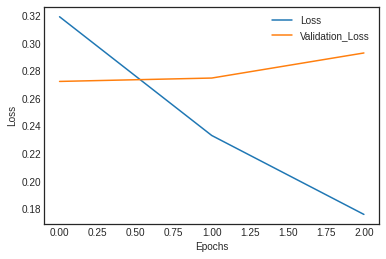

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], "")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Loss', 'Validation_Loss'])
plt.show()

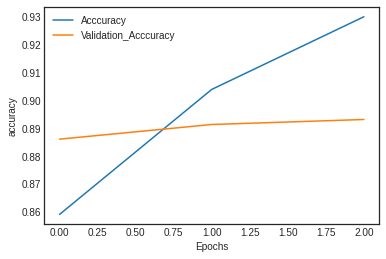

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], "")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(['Acccuracy', 'Validation_Acccuracy'])
plt.show()

## 모델 평가

In [34]:
test_data_sents = []
test_data_labels = []

for test_sent, test_label in test_data[['document', 'label']].values:
  test_tokenized_text = vocab[tokenizer(clean_text(test_sent))]

  tokens = [vocab[vocab.bos_token]]
  tokens += pad_sequences([test_tokenized_text],
                          SENT_MAX_LEN,
                          value = vocab[vocab.padding_token],
                          padding='post').tolist()[0]
  tokens += [vocab[vocab.eos_token]]

  test_data_sents.append(tokens)
  test_data_labels.append(test_label)

test_data_sents = np.array(test_data_sents, dtype=np.int64)
test_data_labels = np.array(test_data_labels, dtype=np.int64)

In [35]:
cls_model.load_weights(checkpoint_path)
cls_model.evaluate(test_data_sents, test_data_labels, batch_size=1024)

49/49 [==============================] - 174s 4s/step - loss: 0.3031 - accuracy: 0.8889


[0.3031465411186218, 0.8888733386993408]